### **3.1. Этап 1. Формирование экспериментального корпуса текстов**

In [6]:
import os
import datetime
import json
import requests
from bs4 import BeautifulSoup
import json
import re
from html import unescape
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


BASE_URL = 'https://www.kommersant.ru/doc/'
START_ID = 8059805
WORD_LIMIT = 50_000
PROCESSED_ARTICLES = set()
encoding='utf-8'

In [ ]:
def fetch_and_parse_article(id):
    url = f'{BASE_URL}{id}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    header = soup.find('h1').text.strip()
    text_elements = soup.find_all(class_="doc__text")
    text = '\n'.join(element.text.strip() for element in text_elements)
    date = soup.find(class_="doc_header__publish_time").text.strip()
    # category = soup.find(class_="doc-breadcrumbs__link")["data-name"]
    category = ""
    
    data = {
        'header': header,
        'date': date,
        'url': url,
        'category': category,
        'text': text,
    }
    
    word_count = len(text.split())
    return data, word_count

def main():
    id = START_ID
    all_articles = []
    current_word_count = 0
    
    while current_word_count < WORD_LIMIT:
        if id in PROCESSED_ARTICLES:
            continue
        
        try:
            article_data, word_count = fetch_and_parse_article(id)
            all_articles.append(article_data)
            current_word_count += word_count
            PROCESSED_ARTICLES.add(id)
        except Exception as e:
            print(f'Ошибка обработки статьи {id}: {e}')
        
        id -= 1
    
    with open('kommersant_articles.jsonl', 'w', encoding=encoding) as f:
        for article in all_articles:
            f.write(json.dumps(article, ensure_ascii=False) + "\n")

if __name__ == "__main__":
    main()

Ошибка обработки статьи 8059730: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059699: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059661: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059612: 'NoneType' object has no attribute 'text'
Ошибка обработки статьи 8059595: 'NoneType' object has no attribute 'text'


### **3.2. Этап 2. Предварительная обработка и очистка текста**
### **3.3. Этап 3. Проектирование универсального модуля предобработки**

In [3]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

In [6]:
def load_jsonl_file(file_path):
    """Загрузка JSONL-файла"""
    with open(file_path, 'r', encoding=encoding) as f:
        data = [json.loads(line.strip()) for line in f]
    return data


def normalize_whitespace(text):
    """Нормализация пробельных символов"""
    normalized_text = re.sub(r'\s+', ' ', text).strip()
    return normalized_text


def remove_html_tags(text):
    """Удаление HTML-тегов"""
    cleaned_text = re.sub('<[^<]+?>', '', text)
    return cleaned_text


def replace_special_tokens(text):
    """Замена чисел, URL и email адресов на специальные маркеры"""
    text = re.sub(r'\b\d+\b', '<NUM>', text)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*$$,]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '<URL>', text)
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '<EMAIL>', text)
    return text


def transform_to_lower_case(text):
    """Приведение текста к нижнему регистру"""
    return text.lower()


def preprocess_category(category):
    """Обработка категории путем удаления ненужных символов"""
    cleaned_category = re.sub(r'[^a-zA-Z]', '', category)
    return cleaned_category.lower() if cleaned_category else None


def filter_stopwords(text, lang='russian'):
    tokens = word_tokenize(text, language=lang)
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords.words(lang)]
    return ' '.join(filtered_tokens)


def clean_and_normalize(data):
    """Основной метод предварительной обработки и очистки"""
    cleaned_data = []

    for item in data:
        try:
            header = normalize_whitespace(item.get('header'))
            date = item.get('date')

            parsed_url = urlparse(item.get('url'))
            path_segments = [seg for seg in parsed_url.path.split('/') if seg]
            clean_url = '/'.join(path_segments[:min(len(path_segments), 3)])

            category = preprocess_category(item.get('category'))

            text = remove_html_tags(unescape(item.get('text')))
            text = replace_special_tokens(normalize_whitespace(text))

            text = filter_stopwords(transform_to_lower_case(text))

            cleaned_item = {
                'header': header,
                'date': date,
                'url': clean_url,
                'category': category,
                'text': text
            }
            cleaned_data.append(cleaned_item)
        except Exception as e:
            print(f"Ошибка при обработке записи: {item}, ошибка: {e}")

    return cleaned_data


if __name__ == "__main__":
    data = load_jsonl_file('kommersant_articles.jsonl')
    
    cleaned_data = clean_and_normalize(data)
    
    with open('processed_dataset.jsonl', 'w', encoding=encoding) as outfile:
        for entry in cleaned_data:
            outfile.write(json.dumps(entry, ensure_ascii=False) + "\n")


### **3.4. Этап 4. Сравнительный анализ методов токенизации и нормализации**

In [13]:
import spacy
from spacy.lang.ru import Russian
from razdel import tokenize as razdel_tokenize

nlp = spacy.load("ru_core_news_sm")

In [ ]:
def load_corpus(file_path):
    corpus = []
    with open(file_path, 'r', encoding=encoding) as f:
        for i, line in enumerate(f):
            data = json.loads(line)
            
            corpus.append(data['header'] + ' ' + data['text'])
    return corpus

#### Токенизация

In [15]:
# Инициализация моделей (один раз)
nlp_spacy = Russian.from_config({"nlp": {"tokenizer": {"@tokenizers": "spacy.Tokenizer.v1"}}})
nlp_spacy.add_pipe("sentencizer") # Добавляем простой компонент для предложений
nltk.download('punkt')

def tokenize_naive(text):
    """Наивная токенизация по пробелам и знакам препинания."""
    # Простой шаблон: слова (кириллица, цифры, дефис) и отдельно знаки препинания
    pattern = r"[\w\-]+|[^\w\s]"
    return re.findall(pattern, text.lower())

def tokenize_regex(text):
    """Более продвинутое регулярное выражение."""
    # Учитываем сокращения и др.
    pattern = r"\b[а-яёa-z0-9]+\b|[!?.,;:]"
    return re.findall(pattern, text.lower())

def tokenize_nltk(text):
    """Токенизация с помощью NLTK."""
    return nltk.word_tokenize(text.lower(), language='russian')

def tokenize_razdel(text):
    """Токенизация с помощью razdel. Сохраняет пробелы и т.д., но мы возьмём только токены."""
    return [token.text.lower() for token in razdel_tokenize(text)]

def tokenize_spacy(text):
    """Токенизация с помощью spaCy."""
    doc = nlp_spacy(text)
    return [token.text.lower() for token in doc]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DmitrievMS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Стемминг и лемматизация

In [19]:
from nltk.stem import SnowballStemmer, PorterStemmer
import pymorphy3
from spacy.lang.ru import Russian as SpacyRussian

# Инициализация (один раз)
nltk_stemmer_porter = PorterStemmer()
nltk_stemmer_snowball = SnowballStemmer(language='russian')
morph_analyzer = pymorphy3.MorphAnalyzer()

# Для spaCy лемматизации нужна модель с лемматизатором
nlp_spacy_lemmatizer = SpacyRussian.from_config({"nlp": {"tokenizer": {"@tokenizers": "spacy.Tokenizer.v1"}}})
nlp_spacy_lemmatizer.add_pipe("lemmatizer", config={"mode": "pymorphy3"}) # Использует pymorphy3 внутри

def stem_porter(tokens):
    return [nltk_stemmer_porter.stem(token) for token in tokens]

def stem_snowball(tokens):
    return [nltk_stemmer_snowball.stem(token) for token in tokens]

def lemmatize_pymorphy2(tokens):
    lemmas = []
    for token in tokens:
        # pymorphy2 возвращает разбор, берем нормальную форму первого варианта
        parsed_token = morph_analyzer.parse(token)[0]
        lemmas.append(parsed_token.normal_form)
    return lemmas

def lemmatize_spacy(tokens):
    # Объединяем токены обратно в текст для обработки spaCy
    text = ' '.join(tokens)
    doc = nlp_spacy_lemmatizer(text)
    return [token.lemma_ for token in doc]

#### Метрики

In [20]:
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def calculate_vocabulary_size(processed_texts):
    """Объём словаря: количество уникальных токенов во всем корпусе после обработки."""
    all_tokens = []
    for text_tokens in processed_texts:
        all_tokens.extend(text_tokens)
    return len(set(all_tokens))

def calculate_oov_rate(original_processed, new_processed):
    """
    Доля OOV (Out-of-Vocabulary).
    % слов из new_processed, которых нет в словаре original_processed.
    """
    vocab_original = set()
    for tokens in original_processed:
        vocab_original.update(tokens)

    oov_count = 0
    total_count = 0
    for tokens in new_processed:
        for token in tokens:
            total_count += 1
            if token not in vocab_original:
                oov_count += 1

    return oov_count / total_count if total_count > 0 else 0

def measure_speed(processing_func, data):
    """Скорость обработки: время обработки всего корпуса."""
    start_time = time.time()
    _ = processing_func(data) # _ означает, что результат нам не важен
    end_time = time.time()
    return end_time - start_time

def calculate_semantic_similarity(original_texts, processed_texts, vectorizer=TfidfVectorizer()):
    """
    Семантическая согласованность через косинусное сходство TF-IDF векторов.
    Сравниваем исходный текст и текст, собранный из обработанных токенов.
    """
    # 1. Восстанавливаем тексты из токенов
    original_joined = [' '.join(tokens) for tokens in original_texts]
    processed_joined = [' '.join(tokens) for tokens in processed_texts]

    # 2. Объединяем все тексты для построения общего словаря TF-IDF
    all_texts = original_joined + processed_joined

    # 3. Создаем матрицу TF-IDF
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    # 4. Разделяем матрицу обратно
    n = len(original_joined)
    matrix_original = tfidf_matrix[:n]
    matrix_processed = tfidf_matrix[n:]

    # 5. Вычисляем попарное косинусное сходство для каждого документа
    similarities = []
    for i in range(n):
        cos_sim = cosine_similarity(matrix_original[i], matrix_processed[i])[0][0]
        # Если оба документа пустые, косинусное сходство не определено (NaN), заменим на 0 или 1
        if np.isnan(cos_sim):
            cos_sim = 1.0 if (not original_joined[i] and not processed_joined[i]) else 0.0
        similarities.append(cos_sim)

    # 6. Возвращаем среднее сходство по корпусу
    return np.mean(similarities)

#### Результаты

In [ ]:
import pandas as pd
from itertools import product

# Загрузка данных
corpus = load_corpus('processed_dataset.jsonl') # Ограничьте для теста
# Токенизируем исходный текст один раз как "оригинал" (база для сравнения)
base_tokenizer = tokenize_razdel # Выберите самый качественный метод как базовый
original_tokenized = [base_tokenizer(text) for text in corpus]

# Определяем конвейеры обработки (токенизатор + нормализатор)
pipelines = {
    'Naive_None': (tokenize_naive, None),
    'Regex_None': (tokenize_regex, None),
    'NLTK_None': (tokenize_nltk, None),
    'Razdel_None': (tokenize_razdel, None),
    'Spacy_None': (tokenize_spacy, None),
    'Razdel_Porter': (tokenize_razdel, stem_porter),
    'Razdel_Snowball': (tokenize_razdel, stem_snowball),
    'Razdel_Pymorphy2': (tokenize_razdel, lemmatize_pymorphy2),
    'Spacy_SpacyLemma': (tokenize_spacy, lemmatize_spacy),
}

results = []

for pipeline_name, (tokenizer, normalizer) in pipelines.items():
    print(f"Обрабатывается: {pipeline_name}")

    # 1. Применяем конвейер ко всему корпусу
    def process_pipeline(texts):
        processed = []
        for text in texts:
            tokens = tokenizer(text)
            if normalizer is not None:
                tokens = normalizer(tokens)
            # Можно добавить фильтрацию стоп-слов или знаков препинания здесь
            processed.append(tokens)
        return processed

    processed_corpus = process_pipeline(corpus)

    # 2. Вычисляем метрики
    vocab_size = calculate_vocabulary_size(processed_corpus)
    oov_rate = calculate_oov_rate(original_tokenized, processed_corpus)
    speed = measure_speed(process_pipeline, corpus)
    semantic_sim = calculate_semantic_similarity(original_tokenized, processed_corpus)

    # 3. Сохраняем результат
    results.append({
        'Pipeline': pipeline_name,
        'Vocabulary_Size': vocab_size,
        'OOV_Rate': oov_rate,
        'Time_Seconds': speed,
        'Semantic_Similarity': semantic_sim
    })

# 4. Создаем DataFrame и сохраняем в CSV
df_results = pd.DataFrame(results)
df_results.to_csv('tokenization_metrics.csv', index=False, encoding=encoding)
print(df_results)

Обрабатывается: Naive_None
Обрабатывается: Regex_None
Обрабатывается: NLTK_None
Обрабатывается: Razdel_None
Обрабатывается: Spacy_None
Обрабатывается: Razdel_Porter
Обрабатывается: Razdel_Snowball
Обрабатывается: Razdel_Pymorphy2
Обрабатывается: Spacy_SpacyLemma
           Pipeline  Vocabulary_Size  OOV_Rate  Time_Seconds  \
0        Naive_None            15828  0.002916      0.018942   
1        Regex_None            15766  0.013538      0.013588   
2         NLTK_None            15879  0.014640      0.225012   
3       Razdel_None            15824  0.000000      0.186172   
4        Spacy_None            15830  0.022106      0.222144   
5     Razdel_Porter            15823  0.001977      0.553377   
6   Razdel_Snowball             8579  0.466129      0.908034   
7  Razdel_Pymorphy2             8699  0.221759      4.408635   
8  Spacy_SpacyLemma             9266  0.212538      5.128886   

   Semantic_Similarity  
0             0.998700  
1             0.998700  
2             0.99870

### **3.5. Этап 5. Обучение подсловных моделей токенизации**

In [4]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors, normalizers
from tokenizers.models import BPE, WordPiece, Unigram
from collections import Counter

In [7]:
def prepare_corpus(file_path, output_file="corpus.txt", max_docs=10000):
    """
    Подготавливает корпус из JSONL в текстовый файл, 
    где каждое предложение на новой строке
    """
    with open(file_path, 'r', encoding=encoding) as f_in, \
         open(output_file, 'w', encoding=encoding) as f_out:
        
        for i, line in enumerate(f_in):
            if i >= max_docs:
                break
            data = json.loads(line)
            text = data['header'] + ' ' + data['text']
            # Записываем текст на отдельной строке
            f_out.write(text + '\n')
    
    return output_file

# Подготовка корпуса
corpus_file = prepare_corpus('processed_dataset.jsonl')

#### Модели

In [8]:
def train_bpe_tokenizer(vocab_size=8000, min_frequency=2):
    """Обучает BPE токенизатор"""
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    
    # Настройка пред-токенизации (разбивка на слова)
    tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
    
    # Настройка нормализации
    tokenizer.normalizer = normalizers.NFC()
    
    # Тренер
    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=min_frequency,
        special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
    )
    
    return tokenizer, trainer

def train_wordpiece_tokenizer(vocab_size=8000, min_frequency=2):
    """Обучает WordPiece токенизатор"""
    tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    
    tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
    tokenizer.normalizer = normalizers.NFC()
    
    trainer = trainers.WordPieceTrainer(
        vocab_size=vocab_size,
        min_frequency=min_frequency,
        special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
    )
    
    return tokenizer, trainer

def train_unigram_tokenizer(vocab_size=8000, min_frequency=2):
    """Обучает Unigram токенизатор"""
    tokenizer = Tokenizer(Unigram())
    
    tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
    tokenizer.normalizer = normalizers.NFC()
    
    trainer = trainers.UnigramTrainer(
        vocab_size=vocab_size,
        min_frequency=min_frequency,
        special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"],
        unk_token="[UNK]"
    )
    
    return tokenizer, trainer

#### Метрики

In [9]:
def calculate_fragmentation_rate(tokenizer, test_texts):
    """
    Вычисляет процент фрагментации слов - доля слов, разбитых на 2+ подслова
    """
    total_words = 0
    fragmented_words = 0
    
    for text in test_texts:
        # Токенизируем текст
        encoding = tokenizer.encode(text)
        
        # Разбиваем на слова (простая эвристика)
        words = text.split()
        total_words += len(words)
        
        # Подсчитываем токены для каждого слова
        word_start = 0
        for word in words:
            word_end = word_start + len(word)
            # Находим токены, соответствующие этому слову
            word_tokens = []
            for token in encoding.tokens:
                token_start = text.find(token, word_start)
                if word_start <= token_start < word_end:
                    word_tokens.append(token)
            
            # Если слово разбито на 2+ токена - считаем фрагментированным
            if len(word_tokens) >= 2:
                fragmented_words += 1
            
            word_start = word_end + 1  # +1 для пробела
    
    return fragmented_words / total_words if total_words > 0 else 0

def calculate_compression_ratio(tokenizer, test_texts):
    """
    Коэффициент сжатия: отношение числа исходных слов к числу токенов после обработки
    """
    total_original_words = 0
    total_tokens = 0
    
    for text in test_texts:
        words = text.split()
        encoding = tokenizer.encode(text)
        
        total_original_words += len(words)
        total_tokens += len(encoding.tokens)
    
    return total_original_words / total_tokens if total_tokens > 0 else 0

def calculate_reconstruction_accuracy(tokenizer, test_texts):
    """
    Эффективность реконструкции - насколько точно модель восстанавливает исходный текст
    """
    total_chars = 0
    correct_chars = 0
    
    for text in test_texts:
        # Токенизируем и декодируем обратно
        encoding = tokenizer.encode(text)
        reconstructed = tokenizer.decode(encoding.ids)
        
        # Сравниваем посимвольно (игнорируем регистр и пробелы)
        original_clean = text.lower().replace(' ', '')
        reconstructed_clean = reconstructed.lower().replace(' ', '')
        
        min_len = min(len(original_clean), len(reconstructed_clean))
        if min_len > 0:
            for i in range(min_len):
                total_chars += 1
                if original_clean[i] == reconstructed_clean[i]:
                    correct_chars += 1
    
    return correct_chars / total_chars if total_chars > 0 else 0

def measure_tokenization_speed(tokenizer, test_texts, iterations=10):
    """Измеряет скорость токенизации"""
    start_time = time.time()
    
    for _ in range(iterations):
        for text in test_texts:
            _ = tokenizer.encode(text)
    
    end_time = time.time()
    return (end_time - start_time) / (len(test_texts) * iterations)

#### Результаты

In [10]:
def save_tokenizer_model(tokenizer, model_name, vocab_size, save_path="saved_models"):
    """Сохраняет обученную модель токенизатора"""
    import os
    from datetime import datetime
    
    # Создаем директорию если не существует
    os.makedirs(save_path, exist_ok=True)
    
    # Генерируем имя файла
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{model_name}_vocab{vocab_size}_{timestamp}"
    filepath = os.path.join(save_path, f"{filename}.json")
    
    # Сохраняем модель
    tokenizer.save(filepath)
    print(f"Модель сохранена: {filepath}")
    
    return filepath

def load_test_texts(corpus_file, num_texts=100):
    """Загружает подмножество текстов для тестирования"""
    texts = []
    with open(corpus_file, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= num_texts:
                break
            texts.append(line.strip())
    return texts

def run_experiment(corpus_file, vocab_sizes=[8000, 16000, 32000], min_frequency=2):
    """Запускает полный эксперимент для всех моделей и размеров словаря"""
    
    test_texts = load_test_texts(corpus_file, num_texts=200)
    results = []
    
    model_configs = [
        ('BPE', train_bpe_tokenizer),
        ('WordPiece', train_wordpiece_tokenizer),
        ('Unigram', train_unigram_tokenizer)
    ]
    
    for model_name, trainer_func in model_configs:
        for vocab_size in vocab_sizes:
            print(f"Обучается {model_name} с vocab_size={vocab_size}")
            
            try:
                # Обучение токенизатора
                tokenizer, trainer = trainer_func(vocab_size, min_frequency)
                tokenizer.train([corpus_file], trainer)
                
                # СОХРАНЕНИЕ МОДЕЛИ
                model_path = save_tokenizer_model(tokenizer, model_name, vocab_size)
                
                # Расчет метрик
                fragmentation = calculate_fragmentation_rate(tokenizer, test_texts)
                compression = calculate_compression_ratio(tokenizer, test_texts)
                reconstruction = calculate_reconstruction_accuracy(tokenizer, test_texts)
                speed = measure_tokenization_speed(tokenizer, test_texts)
                vocab_actual = tokenizer.get_vocab_size()
                
                results.append({
                    'Model': model_name,
                    'Target_Vocab_Size': vocab_size,
                    'Actual_Vocab_Size': vocab_actual,
                    'Fragmentation_Rate': fragmentation,
                    'Compression_Ratio': compression,
                    'Reconstruction_Accuracy': reconstruction,
                    'Speed_tokens_per_sec': 1/speed if speed > 0 else 0,
                    'Training_Time': 0,  # Можно добавить измерение времени обучения
                    'Model_Path': model_path  # Добавляем путь к сохраненной модели
                })
                
            except Exception as e:
                print(f"Ошибка при обучении {model_name} с vocab_size={vocab_size}: {e}")
    
    return pd.DataFrame(results)

# Запуск эксперимента
results_df = run_experiment(corpus_file)
results_df.to_csv('subword_model_comparison.csv', index=False, encoding='utf-8')

Обучается BPE с vocab_size=8000
Модель сохранена: saved_models\BPE_vocab8000_20250927_104253.json
Обучается BPE с vocab_size=16000
Модель сохранена: saved_models\BPE_vocab16000_20250927_104345.json
Обучается BPE с vocab_size=32000
Модель сохранена: saved_models\BPE_vocab32000_20250927_104515.json
Обучается WordPiece с vocab_size=8000
Модель сохранена: saved_models\WordPiece_vocab8000_20250927_104647.json
Обучается WordPiece с vocab_size=16000
Модель сохранена: saved_models\WordPiece_vocab16000_20250927_104849.json
Обучается WordPiece с vocab_size=32000
Модель сохранена: saved_models\WordPiece_vocab32000_20250927_105017.json
Обучается Unigram с vocab_size=8000
Модель сохранена: saved_models\Unigram_vocab8000_20250927_105136.json
Обучается Unigram с vocab_size=16000
Модель сохранена: saved_models\Unigram_vocab16000_20250927_105215.json
Обучается Unigram с vocab_size=32000
Модель сохранена: saved_models\Unigram_vocab32000_20250927_105251.json


#### Визуализация

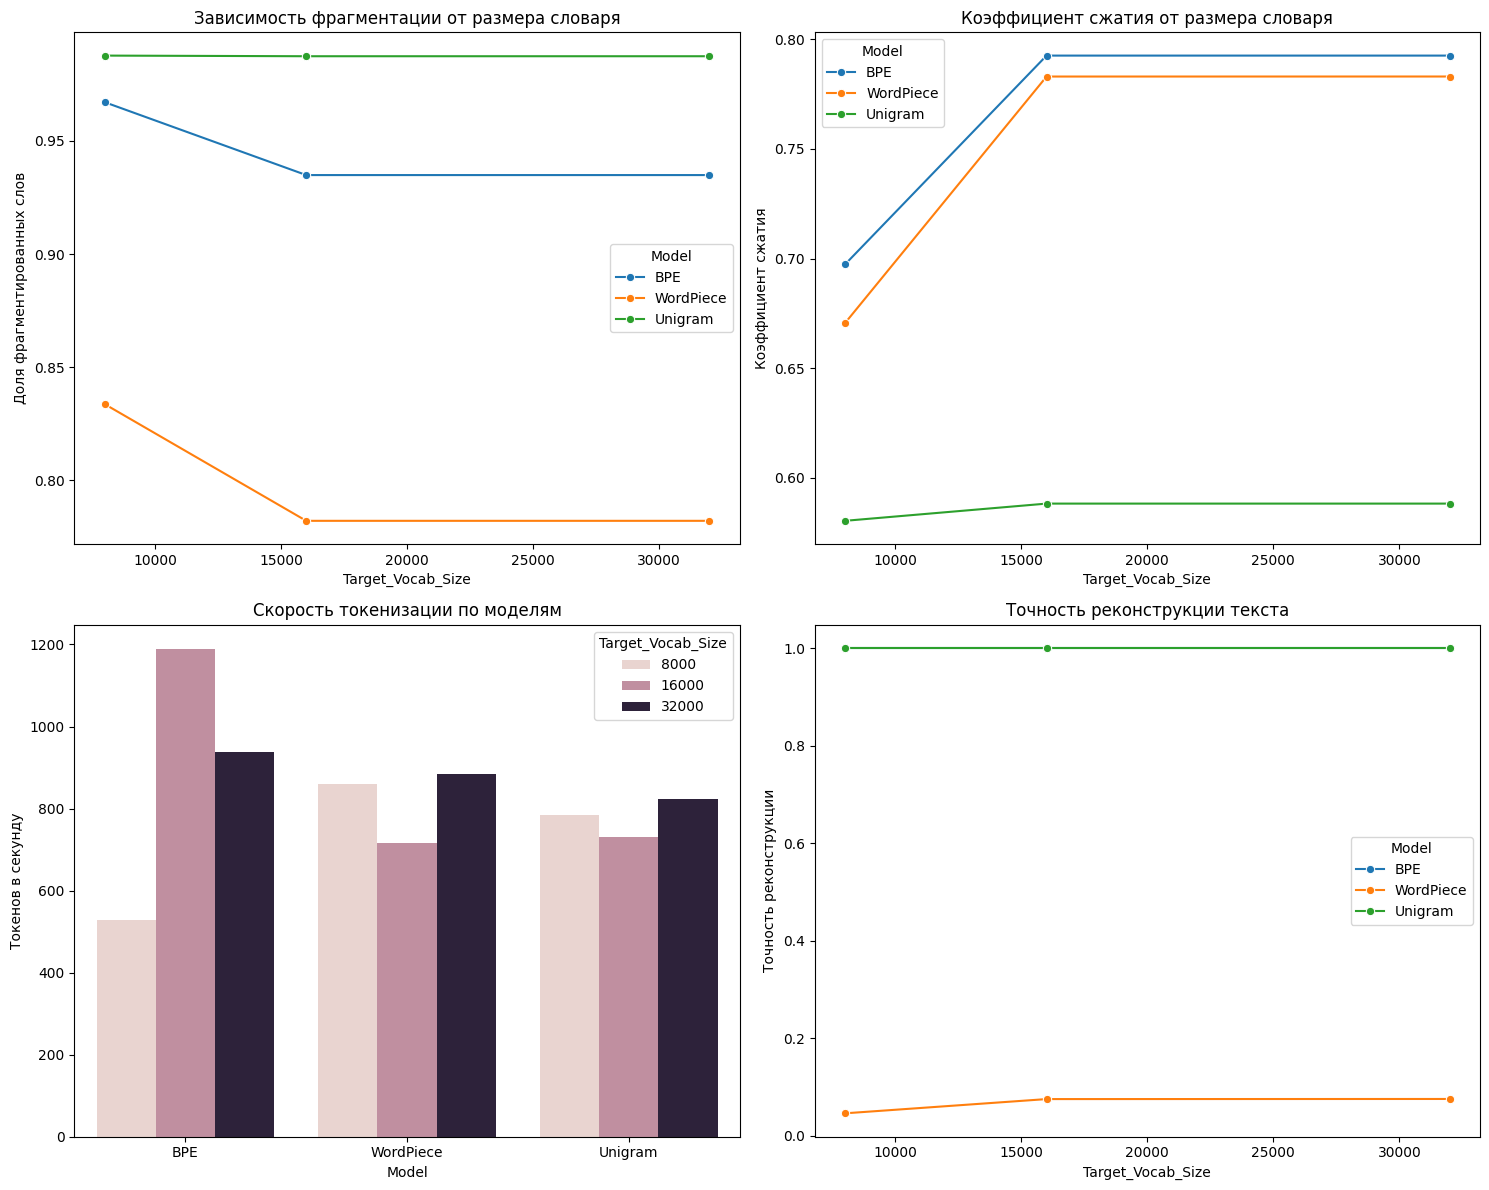

In [14]:
def analyze_tokenization_patterns(tokenizer, sample_texts, model_name, vocab_size):
    """Анализирует паттерны токенизации для конкретной модели"""
    
    analysis_results = []
    
    for text in sample_texts[:5]:  # Анализируем первые 5 текстов
        encoding = tokenizer.encode(text)
        
        analysis_results.append({
            'model': model_name,
            'vocab_size': vocab_size,
            'original_text': text[:100] + '...' if len(text) > 100 else text,
            'original_words': len(text.split()),
            'tokens_count': len(encoding.tokens),
            'tokens': encoding.tokens,
            'fragmented_words': sum(1 for token in encoding.tokens if '##' in token or '▁' in token)
        })
    
    return analysis_results

def create_visualizations(results_df):
    """Создает визуализации для анализа результатов"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Фрагментация vs Размер словаря
    sns.lineplot(data=results_df, x='Target_Vocab_Size', y='Fragmentation_Rate', 
                 hue='Model', marker='o', ax=axes[0, 0])
    axes[0, 0].set_title('Зависимость фрагментации от размера словаря')
    axes[0, 0].set_ylabel('Доля фрагментированных слов')
    
    # 2. Коэффициент сжатия vs Размер словаря
    sns.lineplot(data=results_df, x='Target_Vocab_Size', y='Compression_Ratio', 
                 hue='Model', marker='o', ax=axes[0, 1])
    axes[0, 1].set_title('Коэффициент сжатия от размера словаря')
    axes[0, 1].set_ylabel('Коэффициент сжатия')
    
    # 3. Скорость токенизации
    sns.barplot(data=results_df, x='Model', y='Speed_tokens_per_sec', 
                hue='Target_Vocab_Size', ax=axes[1, 0])
    axes[1, 0].set_title('Скорость токенизации по моделям')
    axes[1, 0].set_ylabel('Токенов в секунду')
    
    # 4. Точность реконструкции
    sns.lineplot(data=results_df, x='Target_Vocab_Size', y='Reconstruction_Accuracy', 
                 hue='Model', marker='o', ax=axes[1, 1])
    axes[1, 1].set_title('Точность реконструкции текста')
    axes[1, 1].set_ylabel('Точность реконструкции')
    
    plt.tight_layout()
    plt.savefig('subword_model_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Создаем визуализации
create_visualizations(results_df)

#### Инференс

In [19]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("saved_models/BPE_vocab8000_20250927_104253.json")
tokenizer.encode("я иду в школу").tokens

['я', 'и', 'ду', 'в', 'шко', 'лу']